In [1]:
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve

<b> Obtain spectrum data from FITS file </b>

In [2]:
def get_intensity_wavelength(filename):
    hdul_image_synth = fits.open(filename)

    synth_data_1 = hdul_image_synth[1].data
    wavelength_synth = synth_data_1['wavelength']
    flux_synth = synth_data_1['flux']
    normalized_flux_synth = synth_data_1['normalized flux']

    return wavelength_synth, flux_synth, normalized_flux_synth

In [3]:
filename = '../Project2/spectral_tests/M_p5500g4.0z0.00t1.0_a0.00c0.00n0.00o0.00r0.00s0.00_VIS.spec.FITS'

In [4]:
wavelength_synth, flux_synth, normalized_flux_synth = get_intensity_wavelength(filename)

In [5]:
len(normalized_flux_synth)

450001

<b> Resolving Power (R = lambda/ delta_lambda) </b>

lambda = average wavelength
delta_lambda = FWHM

* R < 1000 (low resolution)
* 1000 < R < 50000 (intermidiate resolution)
* R > 50000 (high resolution)
* R > 500000 (very high resolution)

In [6]:
# R is assumed to be = 40000
R = 40000

<b> FWHM (delta lambda) - Chromatic Resolution</b>

* FWHM = 2 * sqrt(2*ln(2)) * sigma

In [7]:
def fwhm(wavelength, resolvent_power):

    wavelength_avg = np.mean(wavelength)

    return wavelength_avg/resolvent_power

#fwhm = fwhm(wv_mean, R)

In [8]:
#fwhm

<b> Sigma for Gaussian </b>

In [9]:
def sigma_gaussian(fwhm):
    const = 2 * np.sqrt(2*np.log(2))

    return fwhm/const

#sigma = sigma_gaussian(fwhm)

In [10]:
''' 
Subsituir sufbfunções pelo P (gaussian profile)
'''
def plot_gaussian_P(wavelength, resolvent_power):

    # FWHM
    fwhm_value = fwhm(wavelength, resolvent_power)

    #Sigma Gaussian
    sigma = sigma_gaussian(fwhm_value)

    # Construir a gaussiana
    pixel_size = wavelength[1] - wavelength[0]  # Supor um tamanho de pixel em Å (pequeno para alta resolução)
    x = np.arange(-6 * sigma, 6 * sigma, pixel_size)  # Intervalo centrado em zero
    gaussian_profile = np.exp(-0.5 * (x / sigma) ** 2)
    gaussian_profile /= gaussian_profile.sum()  # Normalizar a gaussiana

    # Calculate FWHM
    FWHM = 2 * np.sqrt(2 * np.log(2)) * sigma
    half_max_intensity = np.max(gaussian_profile) / 2

    # Plotar a gaussiana
    plt.figure(figsize=(8, 5))
    plt.plot(x, gaussian_profile, label=f"Gaussiana (σ = {sigma:.2f} Å)", color="blue")
    plt.axvline(0, color="red", linestyle="--", label="Centro (λ médio)")
    plt.axhline(half_max_intensity, color="green", linestyle="--", label=f"FWHM = {FWHM:.2f} Å")
    plt.xlabel("Wavelength (A)")
    plt.ylabel("Intensidade Normalizada")
    plt.title("Perfil Gaussiano (Instrumental)")
    plt.legend()
    plt.grid(True)
    plt.show()


# Normalizing the Gaussian Profile:
# 
# A Gaussian function is defined as:
# G(x) = A * exp(-x^2 / (2 * sigma^2))
#
# Here:
# - A is the amplitude (which is adjusted during normalization).
# - sigma is the standard deviation, controlling the width of the Gaussian.
# - x is the independent variable (e.g., wavelength offset).
#
# The Gaussian is normalized to ensure that the total area under the curve is 1.
# This is important for preserving the total flux during convolution with the spectrum.
#
# For normalization:
# - The continuous integral of G(x) over all x is:
#   ∫ G(x) dx = sqrt(2 * pi * sigma^2)
# - To normalize the Gaussian, we divide by this total area.
#
# For discrete data (numerical arrays):
# 1. Compute the Gaussian: G(x) = exp(-x^2 / (2 * sigma^2))
# 2. Sum all the Gaussian values: total = sum(G(x))
# 3. Normalize: G_normalized(x) = G(x) / total
#
# In Python:
# gaussian_profile = np.exp(-0.5 * (x / sigma) ** 2)  # Compute the Gaussian
# gaussian_profile /= gaussian_profile.sum()         # Normalize to sum to 1

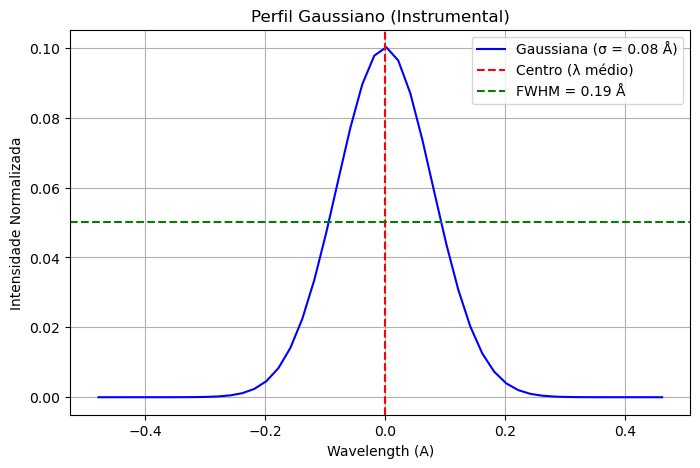

In [11]:
plot_gaussian_P(wavelength_synth, R)

<b> Espetro Simulado </b>

In [12]:
def P(wavelength, resolvent_power):
    # wavelentgth mean
    wv_mean = wavelength.mean()

    # fwhm
    fwhm_v = fwhm(wv_mean, resolvent_power)

    # sigma
    sigma = sigma_gaussian(fwhm_v)
    
    # Construir a gaussiana
    pixel_size = wavelength[1] - wavelength[0]  # Supor um tamanho de pixel em Å (pequeno para alta resolução)
    x = np.arange(-6 * sigma, 6 * sigma, pixel_size)  # Intervalo centrado em zero
    gaussian_profile = np.exp(-0.5 * (x / sigma) ** 2)
    gaussian_profile /= gaussian_profile.sum()  # Normalizar a gaussiana

    return gaussian_profile

P_spectrum = P(wavelength_synth, 40000)
#P = P(wavelength_synth, R)
# E = F (conv) P

In [13]:
# E = F (conv) P
# Convoluir o espectro sintético com a gaussiana
E = convolve(flux_synth, P_spectrum, mode='same')

In [14]:
mask = (wavelength_synth >= 5000) & (wavelength_synth <= 6000)
wavelength_synth[mask]

array([5000.  , 5000.02, 5000.04, ..., 5999.96, 5999.98, 6000.  ],
      dtype='>f8')

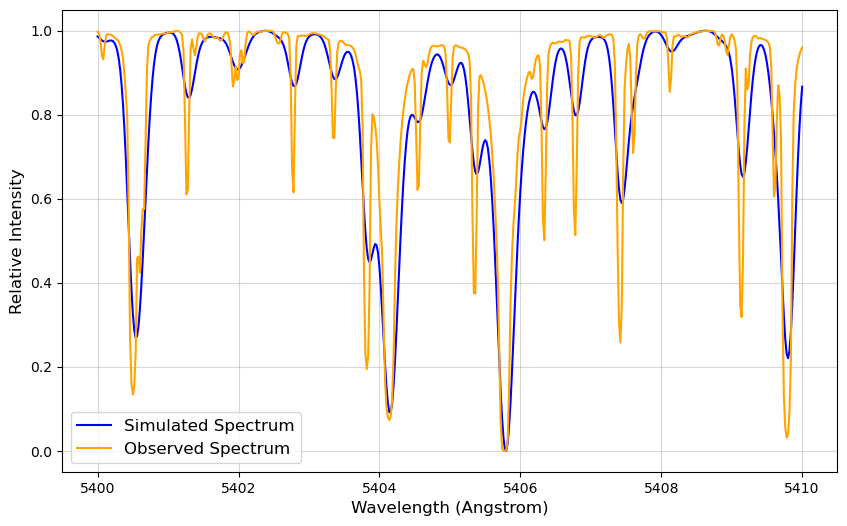

In [15]:
# Plot the spectra (Synthetic/Observed (F) and Instrumental (P)

# Define the wavelength range
min_wavelength = 5400
max_wavelength = 5410

# Create a mask for the wavelength range
mask = (wavelength_synth >= min_wavelength) & (wavelength_synth <= max_wavelength)

# Apply the mask to select the desired range
filtered_wavelength = wavelength_synth[mask]
filtered_flux_synth = flux_synth[mask]
filtered_simulated_flux = E[mask]

# Normalize the flux values to the range [0, 1]
normalized_flux_synth = (filtered_flux_synth - filtered_flux_synth.min()) / (filtered_flux_synth.max() - filtered_flux_synth.min())
normalized_simulated_flux = (filtered_simulated_flux - filtered_simulated_flux.min()) / (filtered_simulated_flux.max() - filtered_simulated_flux.min())

# Plot the normalized data
plt.figure(figsize=(10, 6))
plt.plot(filtered_wavelength, normalized_simulated_flux, label="Simulated Spectrum", color="blue")
plt.plot(filtered_wavelength, normalized_flux_synth, label="Observed Spectrum", color="orange")

# Add labels, title, and legend
plt.xlabel("Wavelength (Angstrom)", fontsize=12)
plt.ylabel("Relative Intensity", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# Show the plot
plt.show()


<b> Rotational Spectrum </b>

In [16]:
'''
def G_1(c, vsinI, wavelength, epsilon):

    # middle point wavelength
    middle_point = len(wavelength)//2
    central_wavelength = wavelength[middle_point]
    
    # delta lamda_m
    delta_lamda_m = (central_wavelength * vsinI) / c

    

    # G
    numerator = ( 2*(1-epsilon) * np.sqrt(1 - (((wavelength-central_wavelength)/delta_lamda_m)**2)) + (np.pi * epsilon)/2 * (1-((wavelength-central_wavelength)/delta_lamda_m)**2))
    denominator = (np.pi * delta_lamda_m * (1 - epsilon/3))

    return numerator/denominator
'''

'\ndef G_1(c, vsinI, wavelength, epsilon):\n\n    # middle point wavelength\n    middle_point = len(wavelength)//2\n    central_wavelength = wavelength[middle_point]\n    \n    # delta lamda_m\n    delta_lamda_m = (central_wavelength * vsinI) / c\n\n    \n\n    # G\n    numerator = ( 2*(1-epsilon) * np.sqrt(1 - (((wavelength-central_wavelength)/delta_lamda_m)**2)) + (np.pi * epsilon)/2 * (1-((wavelength-central_wavelength)/delta_lamda_m)**2))\n    denominator = (np.pi * delta_lamda_m * (1 - epsilon/3))\n\n    return numerator/denominator\n'

In [17]:
from scipy.constants import c
c

299792458.0

In [18]:
import numpy as np

def G_5(c, vsinI, wavelength, epsilon):
    """
    Calculate the rotational broadening profile G(Δλ).
    
    Parameters:
        c: float
            Speed of light (in the same units as vsinI).
        vsinI: float
            Projected rotational velocity (in the same units as c).
        wavelength: array-like
            Wavelength array.
        epsilon: float
            Linear limb-darkening coefficient (0 to 1).
    
    Returns:
        array-like: Rotational profile G(Δλ).
    """
    # Middle point wavelength (assume sorted wavelength array)
    middle_point = len(wavelength) // 2
    central_wavelength = wavelength[middle_point]
    
    # Δλ_m: Rotational broadening half-width
    delta_lambda_m = (central_wavelength * vsinI) / c
    
    # Δλ: Difference between wavelength and center, normalized
    delta_lambda = (wavelength - central_wavelength) / delta_lambda_m

    # Mask for valid values where |Δλ| <= 1
    valid = np.abs(delta_lambda) <= 1

    # Initialize G array with zeros
    G_value = np.zeros_like(wavelength)

    # Compute G(Δλ) only within the valid range
    if np.any(valid):
        term1 = 2 * (1 - epsilon) * np.sqrt(1 - delta_lambda[valid]**2)
        term2 = (np.pi * epsilon / 2) * (1 - delta_lambda[valid]**2)
        denominator = np.pi * delta_lambda_m * (1 - epsilon / 3)

        # Final result
        G_value[valid] = (term1 + term2) / denominator

    return G_value


In [19]:
G_values = G_5(c,20000, wavelength_synth, 0.6)

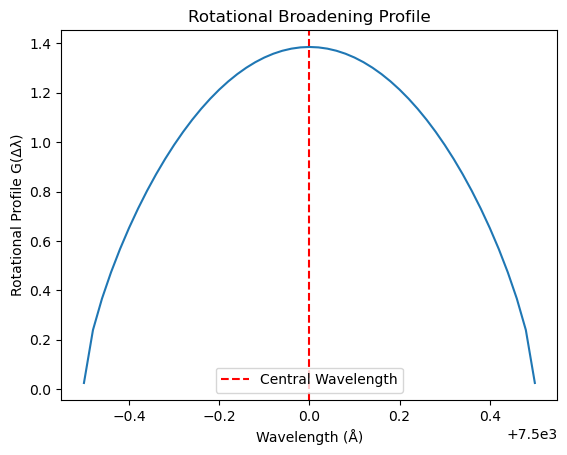

In [20]:
non_zero_indices = np.where(G_values != 0.0)

lambda_min = wavelength_synth[non_zero_indices].min()
lambda_max = wavelength_synth[non_zero_indices].max()

mask_real = (wavelength_synth >= lambda_min) & (wavelength_synth <= lambda_max)

wavelength_synth_filtered = wavelength_synth[mask_real]
g_values_filtered = G_values[mask_real]


central_wavelength = wavelength_synth[len(wavelength_synth) // 2]

plt.axvline(central_wavelength, color='red', linestyle='--', label='Central Wavelength')
plt.legend()
plt.title("Rotational Broadening Profile")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Rotational Profile G(Δλ)")
plt.plot(wavelength_synth_filtered, g_values_filtered)
plt.show()

In [21]:
from numpy import convolve

# Perform convolution
rotation_spectrum = convolve(flux_synth, G_values, mode='same')

In [22]:
'''
from scipy.integrate import simpson
from sklearn.preprocessing import MinMaxScaler

# Redimensionar os dados para o intervalo [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
G_normalized = scaler.fit_transform(G_values.reshape(-1, 1)).flatten()
flux_original_normalized = scaler.fit_transform(flux_synth.reshape(-1, 1)).flatten()
'''

'\nfrom scipy.integrate import simpson\nfrom sklearn.preprocessing import MinMaxScaler\n\n# Redimensionar os dados para o intervalo [0, 1]\nscaler = MinMaxScaler(feature_range=(0, 1))\nG_normalized = scaler.fit_transform(G_values.reshape(-1, 1)).flatten()\nflux_original_normalized = scaler.fit_transform(flux_synth.reshape(-1, 1)).flatten()\n'

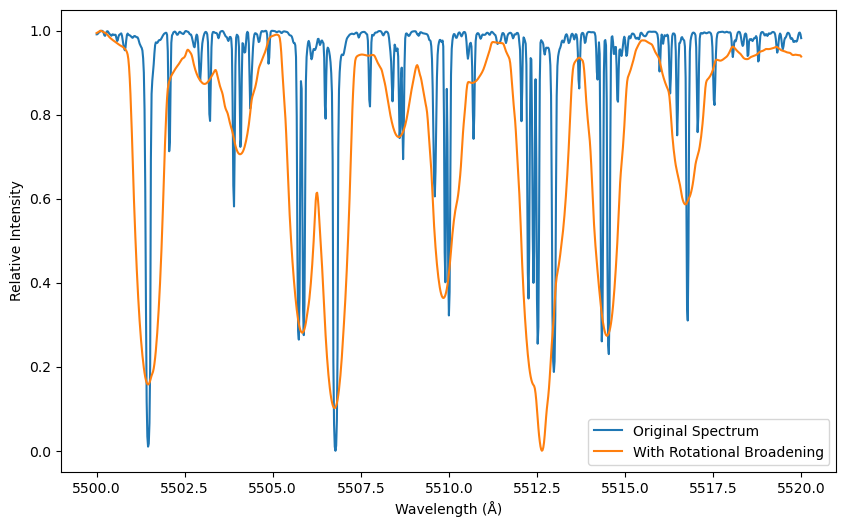

In [23]:
# Spectra comparison: Spectrum without Rotation vs Spectrum with Rotation
lambda_min = 5500 
lambda_max = 5520

mask_real = (wavelength_synth >= lambda_min) & (wavelength_synth <= lambda_max)

wavelength_synth_filtered = wavelength_synth[mask_real]
rotation_values_filtered = rotation_spectrum[mask_real]
filtered_flux_synth = flux_synth[mask_real]


# Normalize the flux values to the range [0, 1]
normalized_flux_synth = (filtered_flux_synth - filtered_flux_synth.min()) / (filtered_flux_synth.max() - filtered_flux_synth.min())
rotation_normalized = (rotation_values_filtered - rotation_values_filtered.min()) / (rotation_values_filtered.max() - rotation_values_filtered.min())

# Plot the normalized data
plt.figure(figsize=(10, 6))
plt.plot(wavelength_synth_filtered, normalized_flux_synth, label="Original Spectrum")
plt.plot(wavelength_synth_filtered, rotation_normalized, label="With Rotational Broadening")
plt.xlabel("Wavelength (Å)")
plt.ylabel("Relative Intensity")
plt.legend()
plt.show()

In [25]:
'''
import numpy as np
import matplotlib.pyplot as plt

def plot_rotational_profile(vsinI, epsilon, central_wavelength, delta_lambda_m):
    # Create wavelength grid centered around 0 with a small step
    x = np.linspace(-2 * delta_lambda_m, 2 * delta_lambda_m, 500)

    # Calculate the rotational profile
    profile = rotational_profile(x + central_wavelength, central_wavelength, vsinI, epsilon, c=3e5)

    # Plot the rotational profile
    plt.figure(figsize=(8, 6))
    plt.plot(x, profile, label=f"vsini={vsinI:.1f} km/s", marker="x", linestyle="-", color="blue")
    
    # Add vertical lines for ±Δλ_M and ±2Δλ_M
    plt.axvline(-delta_lambda_m, color="black", linestyle="-", label="-Δλ_M")
    plt.axvline(delta_lambda_m, color="black", linestyle="-", label="Δλ_M")
    plt.axvline(-2 * delta_lambda_m, color="black", linestyle="--", label="-2Δλ_M")
    plt.axvline(2 * delta_lambda_m, color="black", linestyle="--", label="2Δλ_M")
    plt.axvline(0, color="black", linestyle="-", linewidth=1, label="Center")

    # Label the axes
    plt.xlabel("Wavelength (Å)")
    plt.ylabel("Relative Intensity")
    plt.title("Rotational Profile")
    
    # Annotate Δλ_M labels at the bottom
    plt.text(-delta_lambda_m, -0.002, "-Δλ_M", horizontalalignment="center", verticalalignment="top")
    plt.text(delta_lambda_m, -0.002, "Δλ_M", horizontalalignment="center", verticalalignment="top")
    plt.text(-2 * delta_lambda_m, -0.002, "-2Δλ_M", horizontalalignment="center", verticalalignment="top")
    plt.text(2 * delta_lambda_m, -0.002, "2Δλ_M", horizontalalignment="center", verticalalignment="top")

    # Add legend and grid
    plt.legend()
    plt.grid(True)

    plt.show()

# Example Parameters
vsinI = 20  # Rotational velocity in km/s
epsilon = 0.6  # Limb-darkening coefficient
central_wavelength = 6562.8  # Central wavelength (e.g., H-alpha in Å)
c = 3e5  # Speed of light in km/s
delta_lambda_m = (central_wavelength * vsinI) / c  # Compute Δλ_M

# Plot the rotational profile
plot_rotational_profile(vsinI, epsilon, central_wavelength, delta_lambda_m)
'''

'\nimport numpy as np\nimport matplotlib.pyplot as plt\n\ndef plot_rotational_profile(vsinI, epsilon, central_wavelength, delta_lambda_m):\n    # Create wavelength grid centered around 0 with a small step\n    x = np.linspace(-2 * delta_lambda_m, 2 * delta_lambda_m, 500)\n\n    # Calculate the rotational profile\n    profile = rotational_profile(x + central_wavelength, central_wavelength, vsinI, epsilon, c=3e5)\n\n    # Plot the rotational profile\n    plt.figure(figsize=(8, 6))\n    plt.plot(x, profile, label=f"vsini={vsinI:.1f} km/s", marker="x", linestyle="-", color="blue")\n    \n    # Add vertical lines for ±Δλ_M and ±2Δλ_M\n    plt.axvline(-delta_lambda_m, color="black", linestyle="-", label="-Δλ_M")\n    plt.axvline(delta_lambda_m, color="black", linestyle="-", label="Δλ_M")\n    plt.axvline(-2 * delta_lambda_m, color="black", linestyle="--", label="-2Δλ_M")\n    plt.axvline(2 * delta_lambda_m, color="black", linestyle="--", label="2Δλ_M")\n    plt.axvline(0, color="black", line

In [26]:
# H = I (conv) P
'''
G = G(c, )
# Convoluir o espectro sintético sem rotação com o espetro sintético com rotação
simulated_flux_rotation = convolve(flux_synth, G, mode='same')
'''

"\nG = G(c, )\n# Convoluir o espectro sintético sem rotação com o espetro sintético com rotação\nsimulated_flux_rotation = convolve(flux_synth, G, mode='same')\n"